# Detecção de novas ondas epidemiológicas
A ideia por trás do algoritmo é detectar transições entre as fases de desaceleração e aceleração do número de casos de COVID-19. Isto é, detectar quando a variação diária do número de casos diários confirmados passa de descrescente a crescente.

#### Importação de bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import pylab
# imports for debugging purposes
import readline
import code

#### Funções de filtragem
A aplicação dos filtros, em especial o filtro passa baixas, é importante pois o processo de derivação numérica, que será utilizado, é muito sensível a efeitos de ruído.

In [2]:
# Moving average filter
def moving_average(x, win_size):
    filtered = np.convolve(x, np.ones(win_size), 'valid') / win_size
    filtered = np.append(np.zeros(win_size-1), filtered) # fill the w-1 first slots with zeros
    return filtered

# Median filter
def median_filter(x, win_size):
    S = 1
    nrows = ((x.size-win_size)//S)+1
    n = x.strides[0]
    strided = np.lib.stride_tricks.as_strided(x, shape=(nrows,win_size), strides=(S*n,n))
    filtered  = np.median(strided,axis=1)
    filtered = np.append(np.zeros(win_size-1), filtered) # fill the w-1 first slots with zeros
    return filtered

def butterworth_lowpass_filter(data, cutoff_freq, fs, order=2):
    #fs is the sampling rate
    nyq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # lfilter apply filter along one dimension
    y = lfilter(b, a, data)
    return y

def filter_data(data):    
    # Moving average with 21-day window
    filtered_data = moving_average(data, 14)
    
    # 2nd Order Low-Pass Filter with 14-day window
    order = 2
    fs = len(data) # sampling rate       
    cutoff = 14 # cutoff freq.
    filtered_data =  butterworth_lowpass_filter(filtered_data, cutoff, fs, order)

    # Median filter with 14-day window
    filtered_data = median_filter(filtered_data, 14)

    # Reduce the delay effect introduced by the filtering process
    # Advance the signal by 20 days
    filtered_data = filtered_data[20:]

    return filtered_data

#### Método de Euler (Forward Euler Approximation)
Seja o problema
$$\frac{dy(t)}{dt} = f(t, y)$$
$$y(t_0) = y_0$$
O Método de Euler define que 
$$y_0 = y(t_0)$$
$$y_{i+1} = y_i + h f(t_i, y_i)$$
para $i=1, 2, ...$

Sendo assim, em cada iteração podemos considerar que
$$\frac{dy(t)}{dt} = f(x_i, y_i) = \frac{y_{i+1} -\  y_i}{h} $$

In [3]:
# Forward Euler Approximation (Euler's Method)
def forward_euler(t, step, y, dy0):
    dy = np.zeros(len(t))
    dy[0] = dy0
    for i in range(len(t) - 1):
        dy[i+1] = (y[i+1] - y[i])/step
    return dy

#### Algoritmo de detecção de novas ondas
Para detectar a mudança de um trecho decrescente para um trecho crescente da primeira derivada dos dados acumulados, basta verificar quando a segunda derivada muda de sinal (- para +)

Considera-se, no entanto, um limiar (_threshold_) para definir um intervalo de tolerância ao registrar essa mudança.

In [4]:
# New epidemiological wave detection
#   Receives (sec_der, abs_threshold)
#      sec_der: second derivative of acc. number of cases 
#      abs_threshold: threshold to consider around zero
#   Returns (x_t, y_t) -> coordinates of the transition points 
def new_wave_detection(sec_der, abs_threshold):
    x_t = []
    y_t = []
    for i in range(len(sec_der)-1):
        if((sec_der[i] < abs_threshold) and (sec_der[i+1] > abs_threshold)):
           x_t.append(i+1)
           y_t.append(sec_der[i+1])
    return x_t, y_t


#### Código Principal

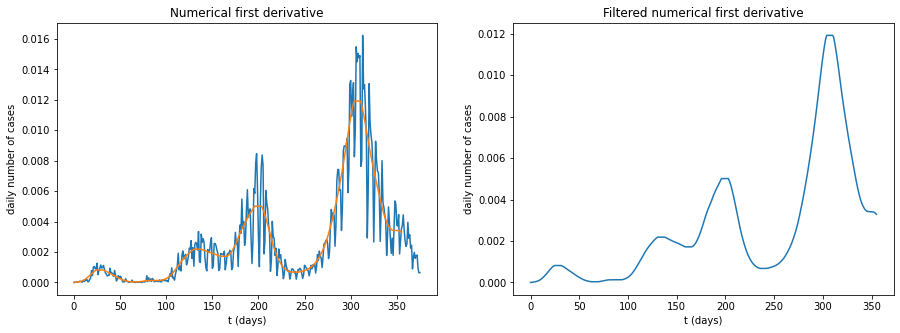

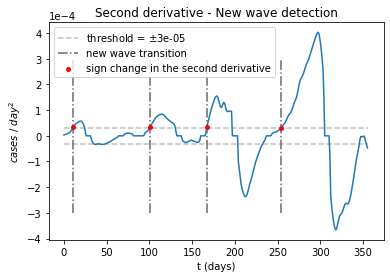

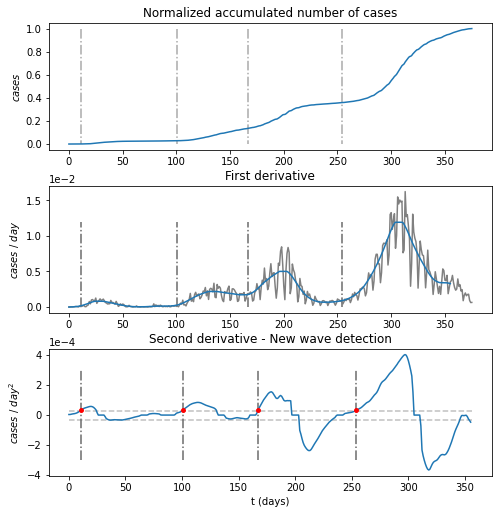

In [5]:
#import data
data = pd.read_csv("../Datasets/jerusalem.csv")  

# Filter data to reduce noise effects
# Normalize by maximum value
normalized_acc_n_cases = data.total_confirmed / max(data.total_confirmed)


t = np.linspace(0, len(normalized_acc_n_cases), len(normalized_acc_n_cases))
daily_n_cases = forward_euler(t, 1, normalized_acc_n_cases, 0)

fig, axs = plt.subplots(1, 2, figsize=(15,5)) # 1 row, 2 cols
axs[0].set_title('Numerical first derivative')
axs[0].plot(daily_n_cases)
axs[0].set_xlabel('t (days)')
axs[0].set_ylabel('daily number of cases')

unf_daily_n_cases = daily_n_cases
daily_n_cases = filter_data(daily_n_cases)

axs[0].plot(daily_n_cases)

axs[1].set_title('Filtered numerical first derivative')
axs[1].plot(daily_n_cases)
axs[1].set_xlabel('t (days)')
axs[1].set_ylabel('daily number of cases')
plt.show()

# Obtain second derivative of the number of cases w.r.t time
# using Forward Euler
t = np.linspace(0, len(daily_n_cases), len(daily_n_cases))
sd0 = daily_n_cases[1] - daily_n_cases[0]
sec_der = forward_euler(t, 1, daily_n_cases, sd0)

# Detection of new waves
abs_threshold = 3e-5
x_t, y_t = new_wave_detection(sec_der, abs_threshold)

pylab.ticklabel_format(axis='y',style='sci',scilimits=(-4,-4))
plt.title("Second derivative - New wave detection")
plt.xlabel("t (days)")
plt.ylabel("$cases$ / $day^2$")
plt.plot(sec_der, zorder=1) # obs: check if this scaling is correct
plt.hlines([-1*abs_threshold, abs_threshold], 0, len(sec_der), colors='silver', linestyles='dashed', zorder=1, label=f"threshold = $\pm${abs_threshold}")
plt.vlines(x_t, -3e-4, 3e-4, colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
plt.scatter(x_t, y_t, s=15, c='r', zorder=2, label="sign change in the second derivative")
plt.legend()
plt.show()

# Graph with acc. data and its first two derivatives
fig, axs = plt.subplots(3, 1, figsize=(7,7)) # 3 rows, 1 col
plt.tight_layout(pad=1.5)
axs[0].plot(normalized_acc_n_cases) # para alinhar as retas de nova onda
axs[0].vlines(x_t, 1, 3e-4, colors='darkgray', linestyles='dashdot', zorder=1, label="new wave transition")
axs[0].set_title('Normalized accumulated number of cases')
axs[0].set_ylabel("$cases$")

axs[1].plot(unf_daily_n_cases, c='gray')
axs[1].plot(daily_n_cases)
axs[1].ticklabel_format(axis='y',style='sci',scilimits=(-2,-2))
axs[1].vlines(x_t, min(daily_n_cases), max(daily_n_cases), colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
axs[1].set_title('First derivative')
axs[1].set_ylabel("$cases$ / $day$")

axs[2].ticklabel_format(axis='y',style='sci',scilimits=(-4,-4))
axs[2].set_title("Second derivative - New wave detection")
axs[2].set_xlabel("t (days)")
axs[2].set_ylabel("$cases$ / $day^2$")
axs[2].plot(sec_der, zorder=1) # obs: check if this scaling is correct
axs[2].hlines([-1*abs_threshold, abs_threshold], 0, len(sec_der), colors='silver', linestyles='dashed', zorder=1, label=f"threshold = $\pm${abs_threshold}")
axs[2].vlines(x_t, -3e-4, 3e-4, colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
axs[2].scatter(x_t, y_t, s=15, c='r', zorder=2, label="sign change in the second derivative")
plt.show()

#====== Interactive Debug ======
# variables = globals().copy()
# variables.update(locals())
# shell = code.InteractiveConsole(variables)
# shell.interact()
#===============================

In [6]:
t = np.linspace(0, len(normalized_acc_n_cases), len(normalized_acc_n_cases))
daily_n_cases = forward_euler(t, 1, normalized_acc_n_cases, 0)
print('acc: ', len(normalized_acc_n_cases))
print('acc: ', len(daily_n_cases))

acc:  376
acc:  376


#### Comparando filtros para entender melhor o Butterworth

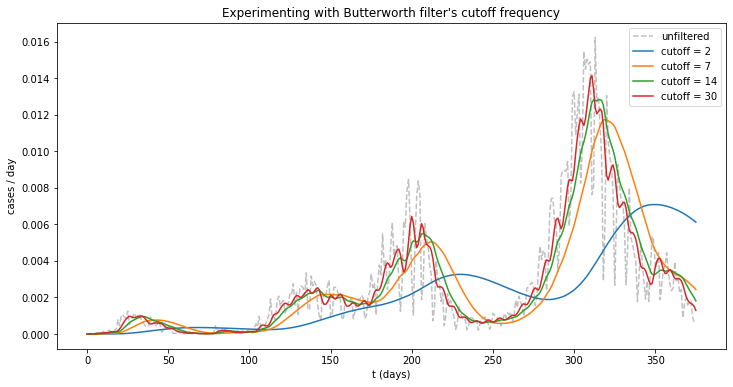

In [8]:
plt.figure(figsize=(12,6))
plt.title("Experimenting with Butterworth filter's cutoff frequency")
plt.xlabel("t (days)")
plt.ylabel("cases / day")

plt.plot(unf_daily_n_cases, label="unfiltered", c='silver', linestyle='dashed')

order = 2
fs = len(data) # sampling rate       

cutoff = 2 # cutoff freq.
filtered =  butterworth_lowpass_filter(unf_daily_n_cases, cutoff, fs, order)
plt.plot(filtered, label=f"cutoff = {cutoff}")

cutoff = 7 # cutoff freq.
filtered =  butterworth_lowpass_filter(unf_daily_n_cases, cutoff, fs, order)
plt.plot(filtered, label=f"cutoff = {cutoff}")

cutoff = 14 # cutoff freq.
filtered =  butterworth_lowpass_filter(unf_daily_n_cases, cutoff, fs, order)
plt.plot(filtered, label=f"cutoff = {cutoff}")

cutoff = 30 # cutoff freq.
filtered =  butterworth_lowpass_filter(unf_daily_n_cases, cutoff, fs, order)
plt.plot(filtered, label=f"cutoff = {cutoff}")

plt.legend()
plt.show()


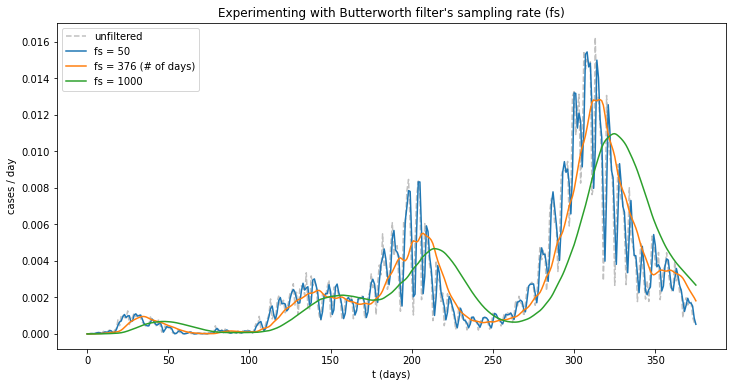

In [9]:
plt.figure(figsize=(12,6))
plt.title("Experimenting with Butterworth filter's sampling rate (fs)")
plt.xlabel("t (days)")
plt.ylabel("cases / day")

plt.plot(unf_daily_n_cases, label="unfiltered", c='silver', linestyle='dashed')

order = 2    
fs = 50 # sampling rate   
cutoff = 14
filtered =  butterworth_lowpass_filter(unf_daily_n_cases, cutoff, fs, order)
plt.plot(filtered, label=f"fs = {fs}")

fs = len(data) # sampling rate   
filtered =  butterworth_lowpass_filter(unf_daily_n_cases, cutoff, fs, order)
plt.plot(filtered, label=f"fs = {fs} (# of days)")

fs = 1000 # sampling rate   
filtered =  butterworth_lowpass_filter(unf_daily_n_cases, cutoff, fs, order)
plt.plot(filtered, label=f"fs = {fs}")

plt.legend()
plt.show()


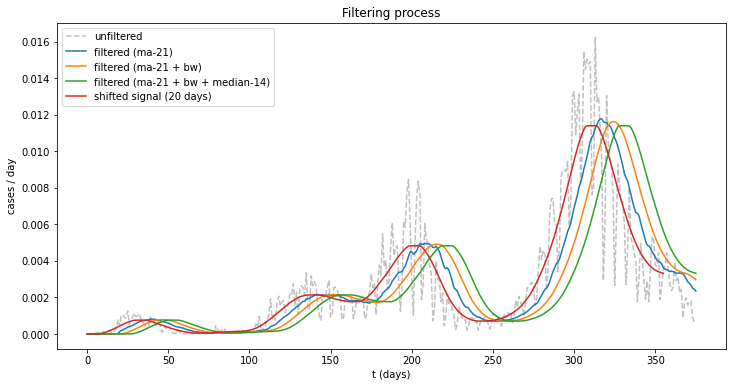

In [10]:
plt.figure(figsize=(12, 6))
plt.title("Filtering process")
plt.xlabel("t (days)")
plt.ylabel("cases / day")

plt.plot(unf_daily_n_cases, label="unfiltered", c='silver', linestyle='dashed')

# Moving average with 21-day window
filtered = moving_average(unf_daily_n_cases, 21)
plt.plot(filtered, label="filtered (ma-21)")

# 2nd Order Low-Pass Filter with 14-day window
order = 2
fs = len(data) # sampling rate       
cutoff = 14 # cutoff freq.
fs = len(data) # sampling rate       
filtered =  butterworth_lowpass_filter(filtered, cutoff, fs, order)
plt.plot(filtered, label="filtered (ma-21 + bw)")

# Median filter with 14-day window
filtered = median_filter(filtered, 14)
plt.plot(filtered, label="filtered (ma-21 + bw + median-14)")

# Shifted signal
n_days_shift = 20
plt.plot(filtered[n_days_shift:], label=f"shifted signal ({n_days_shift} days)")


plt.legend()
plt.show()
